# LG3 Fourier LS Demo

이 노트북은 푸리에(사인/코사인) 기저를 최소제곱으로 적합하고,
어떤 주파수 성분이 사용되는지와 test 데이터에서 해당 신호가 어떻게 나타나는지 보여줍니다.


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROCESSED_TRAIN = "../data/processed/lg3_train.csv"
PROCESSED_TEST = "../data/processed/lg3_test.csv"
FEATURE = "Power"
TOP_K = 12
MAX_FREQ = 60
WINDOW = 200


In [62]:
def build_fourier_design(n, max_freq):
    t = np.arange(n)[:, None]
    cols = [np.ones((n, 1))]
    for k in range(1, max_freq + 1):
        cols.append(np.cos(2 * np.pi * k * t / n))
        cols.append(np.sin(2 * np.pi * k * t / n))
    return np.hstack(cols)

def fit_ls(y, max_freq):
    X = build_fourier_design(len(y), max_freq)
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)
    return coef

def top_k_freqs(coef, max_freq, top_k):
    amps = []
    for k in range(1, max_freq + 1):
        c = coef[1 + 2 * (k - 1)]
        s = coef[2 + 2 * (k - 1)]
        amp = float(np.sqrt(c ** 2 + s ** 2))
        amps.append((k, amp, float(c), float(s)))
    amps.sort(key=lambda x: x[1], reverse=True)
    return amps[:top_k]

def reconstruct_with_freqs(n, freqs, coef):
    t = np.arange(n)
    y_hat = np.ones(n) * coef[0]
    for k, _amp, c, s in freqs:
        y_hat += c * np.cos(2 * np.pi * k * t / n) + s * np.sin(2 * np.pi * k * t / n)
    return y_hat


In [63]:
def random_window(arr, window):
    if len(arr) <= window:
        return arr, 0
    start = np.random.randint(0, len(arr) - window)
    return arr[start:start + window], start


In [64]:
train_df = pd.read_csv(PROCESSED_TRAIN, index_col=0, parse_dates=True)
test_df = pd.read_csv(PROCESSED_TEST, index_col=0, parse_dates=True)

if FEATURE not in train_df.columns:
    raise ValueError(f"{FEATURE} not in train columns")
if FEATURE not in test_df.columns:
    raise ValueError(f"{FEATURE} not in test columns")

train_y = train_df[FEATURE].dropna().values
test_y = test_df[FEATURE].dropna().values

coef = fit_ls(train_y, MAX_FREQ)
top_freqs = top_k_freqs(coef, MAX_FREQ, TOP_K)
print('Top freqs (k, amp, cos, sin):')
for item in top_freqs:
    print(item)

train_hat = reconstruct_with_freqs(len(train_y), top_freqs, coef)
test_hat = reconstruct_with_freqs(len(test_y), top_freqs, coef)


Top freqs (k, amp, cos, sin):
(10, 12.058730334248034, 9.581571840072538, -7.321643145335798)
(1, 11.949209478671216, -11.922425996006842, 0.7996033609898658)
(53, 11.565076181464288, -11.026162742151737, -3.4892294660365186)
(60, 10.155539724362189, 10.0119647893731, 1.7016310262368015)
(7, 8.794874088408775, -7.911307873413333, 3.84200702277238)
(8, 8.109998376638561, 0.16136995443026403, 8.1083927758149)
(18, 7.416762245125369, -4.796392659071357, -5.657117610649747)
(43, 7.409160175100461, 6.623695856887473, 3.3199860987278886)
(54, 6.881021060351404, -2.4318932001646214, 6.436951630701651)
(3, 6.713049933257805, -4.279684081647216, 5.171976756300056)
(21, 6.083179885148919, 5.116464771906852, 3.2904203003441035)
(4, 6.047139671529135, -5.604106797835342, 2.271978258134794)


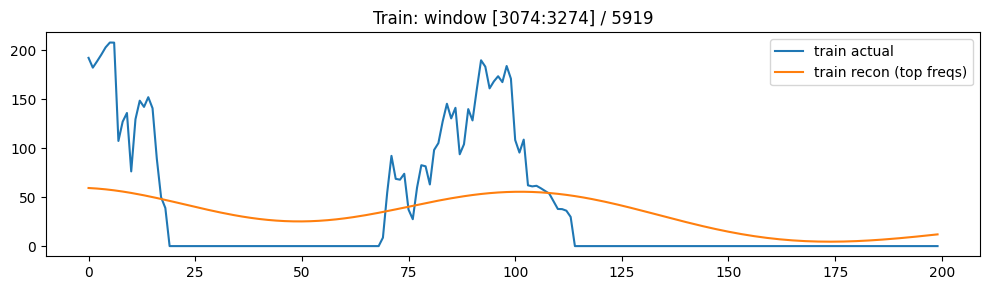

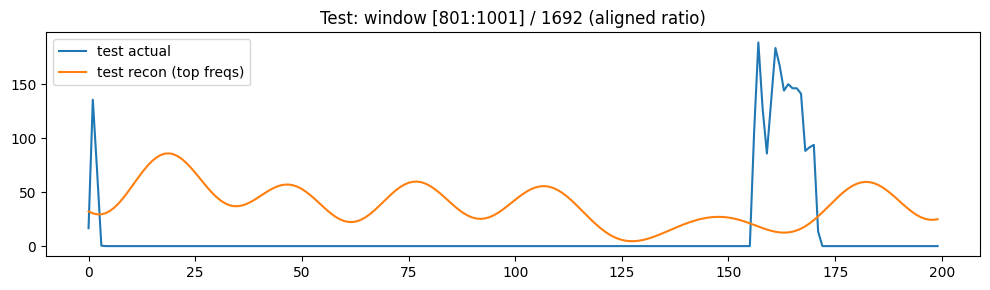

In [65]:
train_seg, train_start = random_window(train_y, WINDOW)
train_hat_seg = train_hat[train_start:train_start + WINDOW]

if len(train_y) > WINDOW and len(test_y) > WINDOW:
    ratio = train_start / max(len(train_y) - WINDOW, 1)
    test_start = int(ratio * (len(test_y) - WINDOW))
else:
    test_start = 0
test_seg = test_y[test_start:test_start + WINDOW]
test_hat_seg = test_hat[test_start:test_start + WINDOW]

plt.figure(figsize=(10, 3))
plt.plot(train_seg, label='train actual')
plt.plot(train_hat_seg, label='train recon (top freqs)')
plt.legend()
plt.title(f'Train: window [{train_start}:{train_start + WINDOW}] / {len(train_y)}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(test_seg, label='test actual')
plt.plot(test_hat_seg, label='test recon (top freqs)')
plt.legend()
plt.title(f'Test: window [{test_start}:{test_start + WINDOW}] / {len(test_y)} (aligned ratio)')
plt.tight_layout()
plt.show()
